# BAL

Ikhlastyar Kalman Achmad

Muhammad Faisa Ardra R.

Muhammad Rafli Azrarsyah

# 0. Configuration and General Library Import

Dilakukan **inisialisasi dan konfigurasi** untuk keseluruhan *notebook*, antara lain:

* **Impor Dependensi:** Mengimpor seluruh *library* dan modul yang diperlukan untuk pemrosesan data (`pandas`, `numpy`), pembangunan model *deep learning* (`tensorflow`, `keras`, `keras_cv`), dan utilitas *machine learning* (`sklearn`).
* **Optimasi Performa:** Menerapkan dua optimasi TensorFlow krusial. `mixed_precision` ('mixed_float16') diaktifkan untuk mempercepat pelatihan pada GPU/TPU, dan `JIT (Just-In-Time) compilation` diaktifkan untuk optimasi eksekusi *graph* komputasi.
* **Definisi Hiperparameter Global:** Menetapkan variabel-variabel krusial yang akan digunakan di seluruh *notebook*, seperti `SEED`, `IMG_SIZE` (target resolusi gambar), `BATCH_SIZE`, dan `N_SPLITS` (untuk *cross-validation*).
* **Pengaturan Path:** Mendefinisikan *path* (jalur) absolut ke direktori data latih (`TRAIN_DIR`) dan uji (`TEST_DIR`).
* **Reproducibility:** Mengeksekusi fungsi `set_all_seeds` untuk mengatur *seed* yang konsisten pada `random`, `numpy`, dan `tensorflow`, yang merupakan langkah fundamental untuk memastikan hasil eksperimen dapat direplikasi secara konsisten.

In [17]:
import os, gc, keras_cv, random, cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from tensorflow import keras
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks

tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True) 

SEED = 42
IMG_SIZE = (320, 320)
BATCH_SIZE = 16

ROOT = Path('/kaggle/working')
TRAIN_DIR = Path('/kaggle/input/data-mining-action-2025/Data Mining Action 2025/Data Mining Action 2025/train split')
TEST_DIR = Path('/kaggle/input/data-mining-action-2025/Data Mining Action 2025/Data Mining Action 2025/test')

def set_all_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_all_seeds()
print('You are all set!')

You are all set!


# 1. Load Data

Pada tahap ini, **kami melakukan pemuatan dan pra-pemrosesan data** dari direktori gambar. Kami menginisialisasi proses dengan memindai (`scan`) setiap *sub-folder* di dalam direktori `TRAIN_DIR`, di mana setiap *sub-folder* dianggap sebagai kelas yang unik. Untuk setiap *sub-folder* kelas, kami mengumpulkan **lokasi *file* (filepath)** dari semua gambar dengan ekstensi yang valid (seperti .jpg, .jpeg, .png).

Seluruh *filepath* ini, beserta **label kelas** (yang diekstrak dari nama *sub-folder*), kemudian disusun ke dalam sebuah DataFrame `pandas` untuk mempermudah manajemen dan analisis data.

Terakhir, untuk mempersiapkan data agar dapat diproses oleh model *deep learning*, kami menerapkan ***label encoding***. Kami menggunakan `LabelEncoder` dari `sklearn` untuk **mengubah label kelas** yang semula berupa teks (kategorikal) menjadi representasi numerik (integer). Daftar nama kelas aslinya juga kami simpan untuk referensi di masa mendatang.

In [18]:
data = []
for class_dir in TRAIN_DIR.iterdir():
    if class_dir.is_dir():
        for ext in ('*.jpg', '*.jpeg', '*.png', '*.bmp'):
            for img_path in class_dir.glob(ext):
                data.append({'filepath': str(img_path), 'label': class_dir.name})

df = pd.DataFrame(data)
print(f"Data total: {len(df)} | Unique classes: {df['label'].nunique()}")

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
class_names = le.classes_

Data total: 3909 | Unique classes: 15


In [15]:
y = df['label']
train_df, test_df = train_test_split(
    df,                
    test_size=0.2,     
    random_state=42,   
    stratify=y         
)

# 2. Exploratory Data Analysis

Untuk memahami komposisi dataset, kami melakukan **analisis distribusi kelas**.

Kami memulai dengan mengidentifikasi semua *sub-folder* (kelas) di dalam `TRAIN_DIR`. Kemudian, kami menghitung jumlah *file* (gambar) di dalam setiap *sub-folder* tersebut untuk mendapatkan jumlah data per kelas.

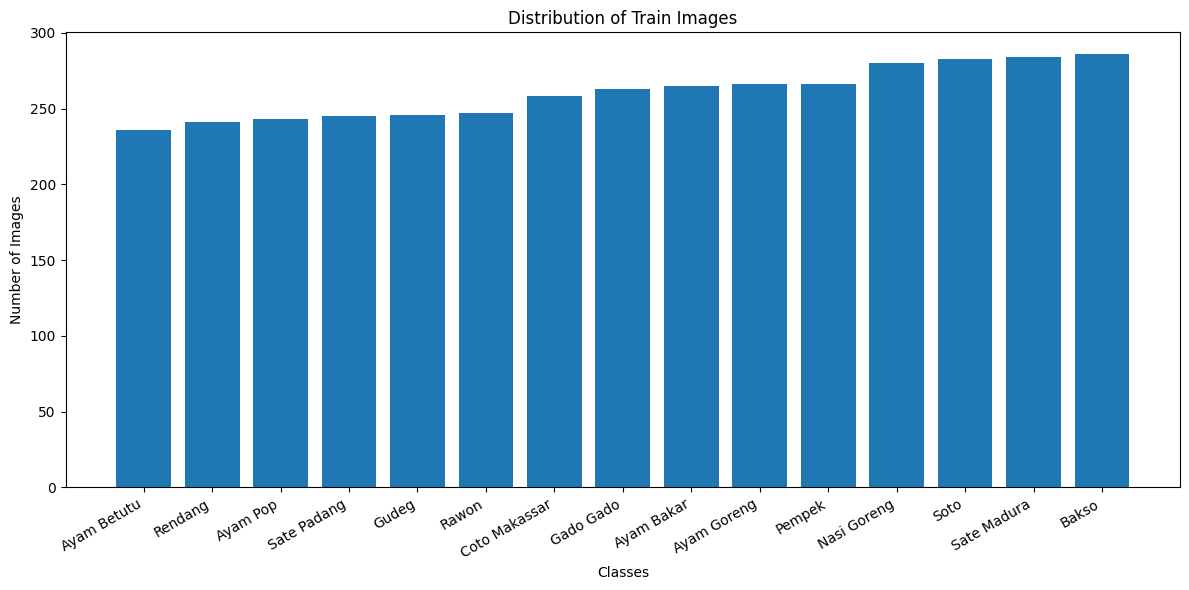

In [16]:
classes = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
data_counts = {cls: len(list((TRAIN_DIR / cls).glob('*'))) for cls in classes}
df_counts = pd.DataFrame(
    list(data_counts.items()), 
    columns=['Class', 'Count']
).sort_values('Count', ascending=True)

plt.figure(figsize=(12,6))
plt.bar(df_counts.Class, df_counts.Count)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Classes")
plt.ylabel("Number of Images") 
plt.title("Distribution of Train Images")
plt.tight_layout()
plt.show()

Hasil perhitungan ini kami visualisasikan menggunakan *bar chart* `matplotlib`. Berdasarkan visualisasi tersebut, kami mengonfirmasi bahwa dataset yang digunakan **cukup seimbang (*well-balanced*)**. Sebagian besar kelas memiliki jumlah data yang relatif seragam, berada dalam rentang **250 hingga 300 gambar per kelas**. Ini menunjukkan tidak ada kelas yang terlalu dominan (mayoritas) atau terlalu sedikit (minoritas), yang merupakan kondisi ideal untuk memulai pelatihan model.

Resized to (128, 128)...


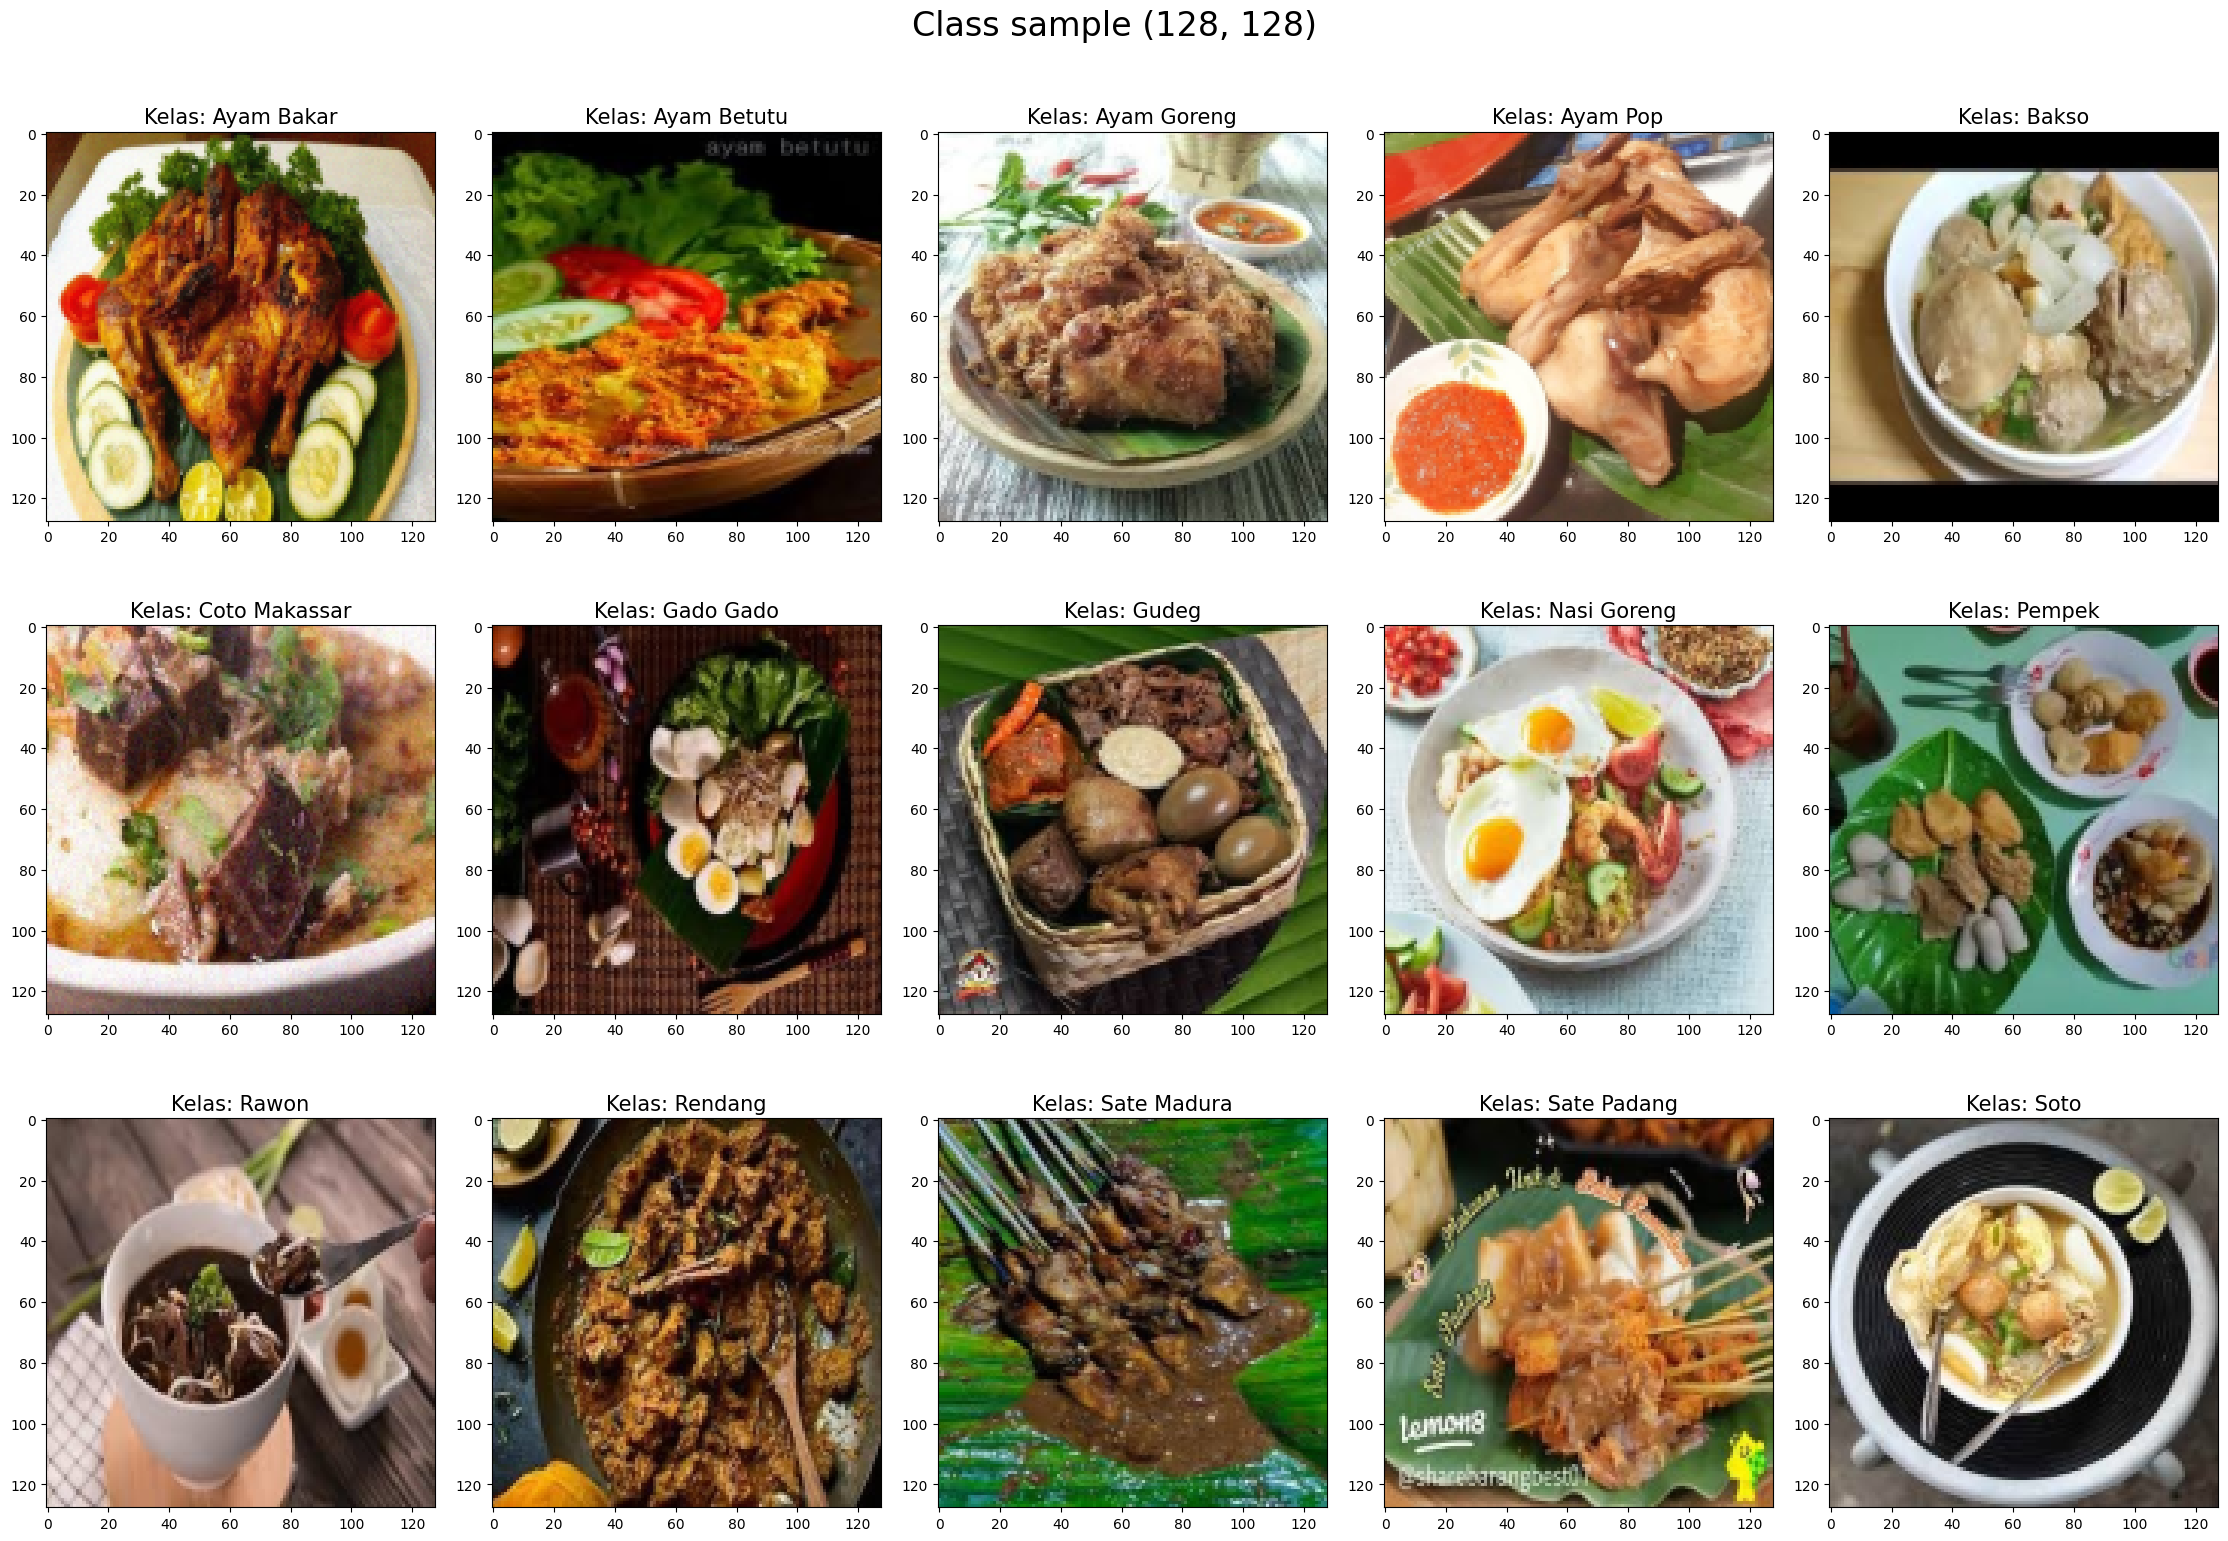

In [17]:
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 5))
axes = axes.flatten()

print(f"Resized to {IMG_SIZE}...")
for i, class_name in enumerate(class_names):
    if i >= len(axes): 
        break
        
    class_filepaths = df[df['label'] == class_name]['filepath'].values
    
    if len(class_filepaths) > 0:
        img_path = random.choice(class_filepaths)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
        ax = axes[i]
        ax.imshow(img_resized)
        ax.set_title(f"Kelas: {class_name}", fontsize=15)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=1.5)
plt.suptitle(f'Class sample {IMG_SIZE}', fontsize=24, y=1.04)
plt.show()

In [18]:
class_weights_arr = compute_class_weight(
            class_weight='balanced',
            classes=df['label'].unique(),
            y=df['label']
)
        
class_weights = dict(enumerate(class_weights_arr))

print('Class weights:')
{class_names[idx]:round(weight,2) for idx, weight in class_weights.items()}

Class weights:


{'Ayam Bakar': 1.07,
 'Ayam Betutu': 0.91,
 'Ayam Goreng': 0.98,
 'Ayam Pop': 1.06,
 'Bakso': 0.98,
 'Coto Makassar': 1.06,
 'Gado Gado': 0.98,
 'Gudeg': 1.01,
 'Nasi Goreng': 1.08,
 'Pempek': 0.93,
 'Rawon': 0.92,
 'Rendang': 1.1,
 'Sate Madura': 1.06,
 'Sate Padang': 0.99,
 'Soto': 0.92}

# 3. Helpers


Merangkum fungsi utilitas yang membuat alur kerja pelatihan lebih rapi, modular, dan dapat diulang: mulai dari membaca dan menyiapkan data gambar ke format model (decode_image), membangun pipeline tf.data yang efisien untuk train/validasi (build_dataset, build_splitted_ds), memvisualkan metrik agar mudah memantau konvergensi dan gejala overfitting (plot_training_history), hingga menyimpan model akhir secara bersih dengan opsi mengambil bobot EMA bila digunakan (save_clean_model). Dengan pemisahan ini, penggantian backbone, pengaturan batch/augmentasi, atau strategi fine-tuning dapat dilakukan konsisten tanpa menyentuh banyak bagian kode.

## Dataset Builder

Menyiapkan pipeline data untuk loop pelatihan tunggal (bukan k-fold) dan membangun test set untuk prediksi. Modul ini membentuk pasangan train/validation sesuai split yang telah ditentukan, menerapkan pra-proses dan (jika perlu) augmentasi yang konsisten hanya pada train, lalu membungkusnya ke tf.data dengan shuffle (train saja), cache, batching, dan prefetch agar pelatihan stabil dan efisien. Untuk test dataset, hanya dilakukan pra-proses yang sama tanpa augmentasi agar alur inferensi mencerminkan pelatihan. Penetapan seed dan parameter umum dilakukan terpusat guna menjaga reproducibility, sehingga perubahan backbone atau konfigurasi batch dapat dilakukan tanpa menyentuh bagian lain dari notebook.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
            
    num_classes = 15 
    label_one_hot = tf.one_hot(label, depth=num_classes)
    
    return img, label_one_hot

def build_dataset(
    paths, labels, batch_size=32, shuffle=False
):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    if shuffle:
        ds = ds.shuffle(
            buffer_size=len(paths),
            seed=SEED, reshuffle_each_iteration=True
        )
        
    ds = ds.map(decode_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    
    return ds.prefetch(AUTOTUNE)

def build_splitted_ds(
    train_df, val_df, batch_size=BATCH_SIZE
):
    train_ds = build_dataset(train_df.filepath, train_df.label_enc,
                             batch_size=batch_size, shuffle=True)
    val_ds   = build_dataset(val_df.filepath, val_df.label_enc,
                            batch_size=batch_size, shuffle=False)
    
    return train_ds, val_ds

def load_test_images(folder, img_size=IMG_SIZE):
    filepaths, images = [], []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, f)
                try:
                    img = Image.open(path).convert("RGB").resize(img_size)
                    img = np.array(img)
                    images.append(img)
                    filepaths.append(f)
                except Exception as e:
                    print(f"Gagal load {f}: {e}")
    return np.array(images), filepaths

## History Plotting

Tujuan utama plotting training history adalah untuk memantau dan mendiagnosis performa model selama proses pelatihan. Dengan memvisualisasikan metrik (seperti loss dan akurasi) pada data training dan data validasi secara bersamaan, kita bisa langsung mengidentifikasi masalah kritis. Kita dapat melihat secara jelas apakah model mengalami overfitting (saat loss validasi memburuk sementara loss training membaik) atau underfitting (saat kedua loss stagnan dan buruk), yang membantu kita memutuskan kapan harus menghentikan pelatihan atau menyesuaikan model.

In [22]:
def training_history(
    head_history, fine_history
):
    boundary_epoch = len(head_history['loss']) - 0.5
    
    combined_history = {}
    for key in head_history.keys():
        if key in fine_history:
            combined_history[key] = head_history[key] + fine_history[key]
            
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    fig.suptitle('Training Summary (Head + Fine-Tuning)', fontsize=17, y=1.0)

    if 'val_loss' in combined_history:
        ax1.plot(combined_history['loss'], label='Training Loss', color='red', linestyle='--')
        ax1.plot(combined_history['val_loss'], label='Validation Loss', color='blue')
        ax1.set_title('Loss (Training vs. Validation)', fontsize=16)
    else:
        ax1.plot(combined_history['loss'], label='Training Loss', color='blue')
        ax1.set_title('Training Loss')
        
    ax1.axvline(x=boundary_epoch, color='black', linestyle='--', label='Mulai Fine-Tuning')
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.7)

    acc_key = None
    if 'accuracy' in combined_history:
        acc_key = 'accuracy'
    elif 'acc' in combined_history:
        acc_key = 'acc'
        
    val_acc_key = None
    if 'val_accuracy' in combined_history:
        val_acc_key = 'val_accuracy'
    elif 'val_acc' in combined_history:
        val_acc_key = 'val_acc'

    if acc_key:
        if val_acc_key:
            ax2.plot(combined_history[acc_key], label='Training Accuracy', color='red', linestyle='--')
            ax2.plot(combined_history[val_acc_key], label='Validation Accuracy', color='blue')
            ax2.set_title('Accuracy (Training vs. Validation)', fontsize=16)
        else:
            ax2.plot(combined_history[acc_key], label='Training Accuracy', color='orange')
            ax2.set_title('Training Accuracy')
        
        ax2.axvline(x=boundary_epoch, color='black', linestyle='--', label='Mulai Fine-Tuning')

        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, linestyle=':', alpha=0.7)
    else:
        ax2.text(0.5, 0.5, 'No "accuracy" found', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=ax2.transAxes)
        ax2.set_title('Accuracy')
        
    
    plt.tight_layout()

## Save Model

In [21]:
def save_clean_model(trained_model, final_filename):
    if not final_filename.endswith('.keras'):
        final_filename += '.keras'
        
    print(f"--- Clean Saving '{final_filename}' ---")

    try:
        print("1. Mengkloning arsitektur model...")
        model_baru = keras.models.clone_model(trained_model)
        
        final_weights = None
        
        try:
            print("2. Mencoba mengekstrak bobot EMA...")
            ema_weights_list = trained_model.optimizer.inner_optimizer._model_variables_moving_average
            ema_weights_numpy = [v.numpy() for v in ema_weights_list]
            print("   -> Bobot EMA ditemukan. Menggabungkan dengan bobot non-trainable...")
            
            final_weights_list = []
            ema_iterator = iter(ema_weights_numpy)

            for weight_variable in trained_model.weights:
                if weight_variable.trainable:
                    final_weights_list.append(next(ema_iterator))
                else:
                    final_weights_list.append(weight_variable.numpy())
            
            final_weights = final_weights_list
            print(f"   -> Daftar bobot (EMA) final lengkap: {len(final_weights)} bobot.")
            
        except AttributeError:
            print("   -> Bobot EMA tidak ditemukan.")
            print("2. Menggunakan bobot standar model (non-EMA).")
            final_weights = trained_model.get_weights()
            print(f"   -> Daftar bobot (Standar) final lengkap: {len(final_weights)} bobot.")


        print("4. Menerapkan bobot bersih ke model kloning...")
        model_baru.set_weights(final_weights)

        print(f"\n5. Menyimpan model bersih ke '{final_filename}'...")
        if os.path.exists(final_filename):
            os.remove(final_filename)
            print(f"   -> File lama '{final_filename}' dihapus.")
            
        model_baru.save(final_filename)

        print("\n--- SELESAI ---")
        print(f"✅ Model bersih berhasil disimpan! (Perkiraan Ukuran: ~{len(final_weights) * 4 / 1024**2:.1f}MB)")
        
        !ls -lh {final_filename}

    except Exception as e:
        print(f"\n--- TERJADI ERROR ---")
        print(f"Gagal menyimpan model. Error: {e}")

# 4. Models Architecture Building

Kami memilih empat arsitektur model: ResNet50, EfficientNetB4, EfficientNetV2S, dan ConvNeXtTiny. Pilihan ini didasarkan pada dua strategi utama:
- Kekuatan Transfer Learning: Dataset kami (3909 gambar) relatif kecil untuk deep learning. Oleh karena itu, kami menggunakan model pre-trained (dilatih pada ImageNet). Ini memungkinkan kami memanfaatkan fitur-fitur visual kompleks yang telah dipelajari model-model tersebut, sehingga mencegah overfitting dan mempercepat konvergensi.

- Keragaman Arsitektur untuk Ensembling: Keempat model ini berasal dari "keluarga" desain yang berbeda:
    - EfficientNet (V2S): Arsitektur modern yang fokus pada efisiensi dan compound scaling untuk akurasi tinggi.
    - ConvNeXtTiny: Arsitektur hibrida terbaru yang mengadopsi prinsip desain dari Vision Transformers ke dalam ConvNet murni.
    - DenseNet169: Arsitektur yang memanfaatkan konektivitas padat (dense connectivity), di mana setiap layer menerima feature map dari semua layer sebelumnya untuk mendorong penggunaan ulang fitur (feature reuse) secara maksimal.

Keragaman ini sangat penting. Setiap model cenderung belajar representasi fitur yang sedikit berbeda dan membuat jenis kesalahan yang berbeda pula. Dengan menggabungkan prediksi mereka (via ensembling), kami bertujuan untuk meniadakan kesalahan individu dan mencapai akurasi akhir yang lebih tinggi dan lebih robust.

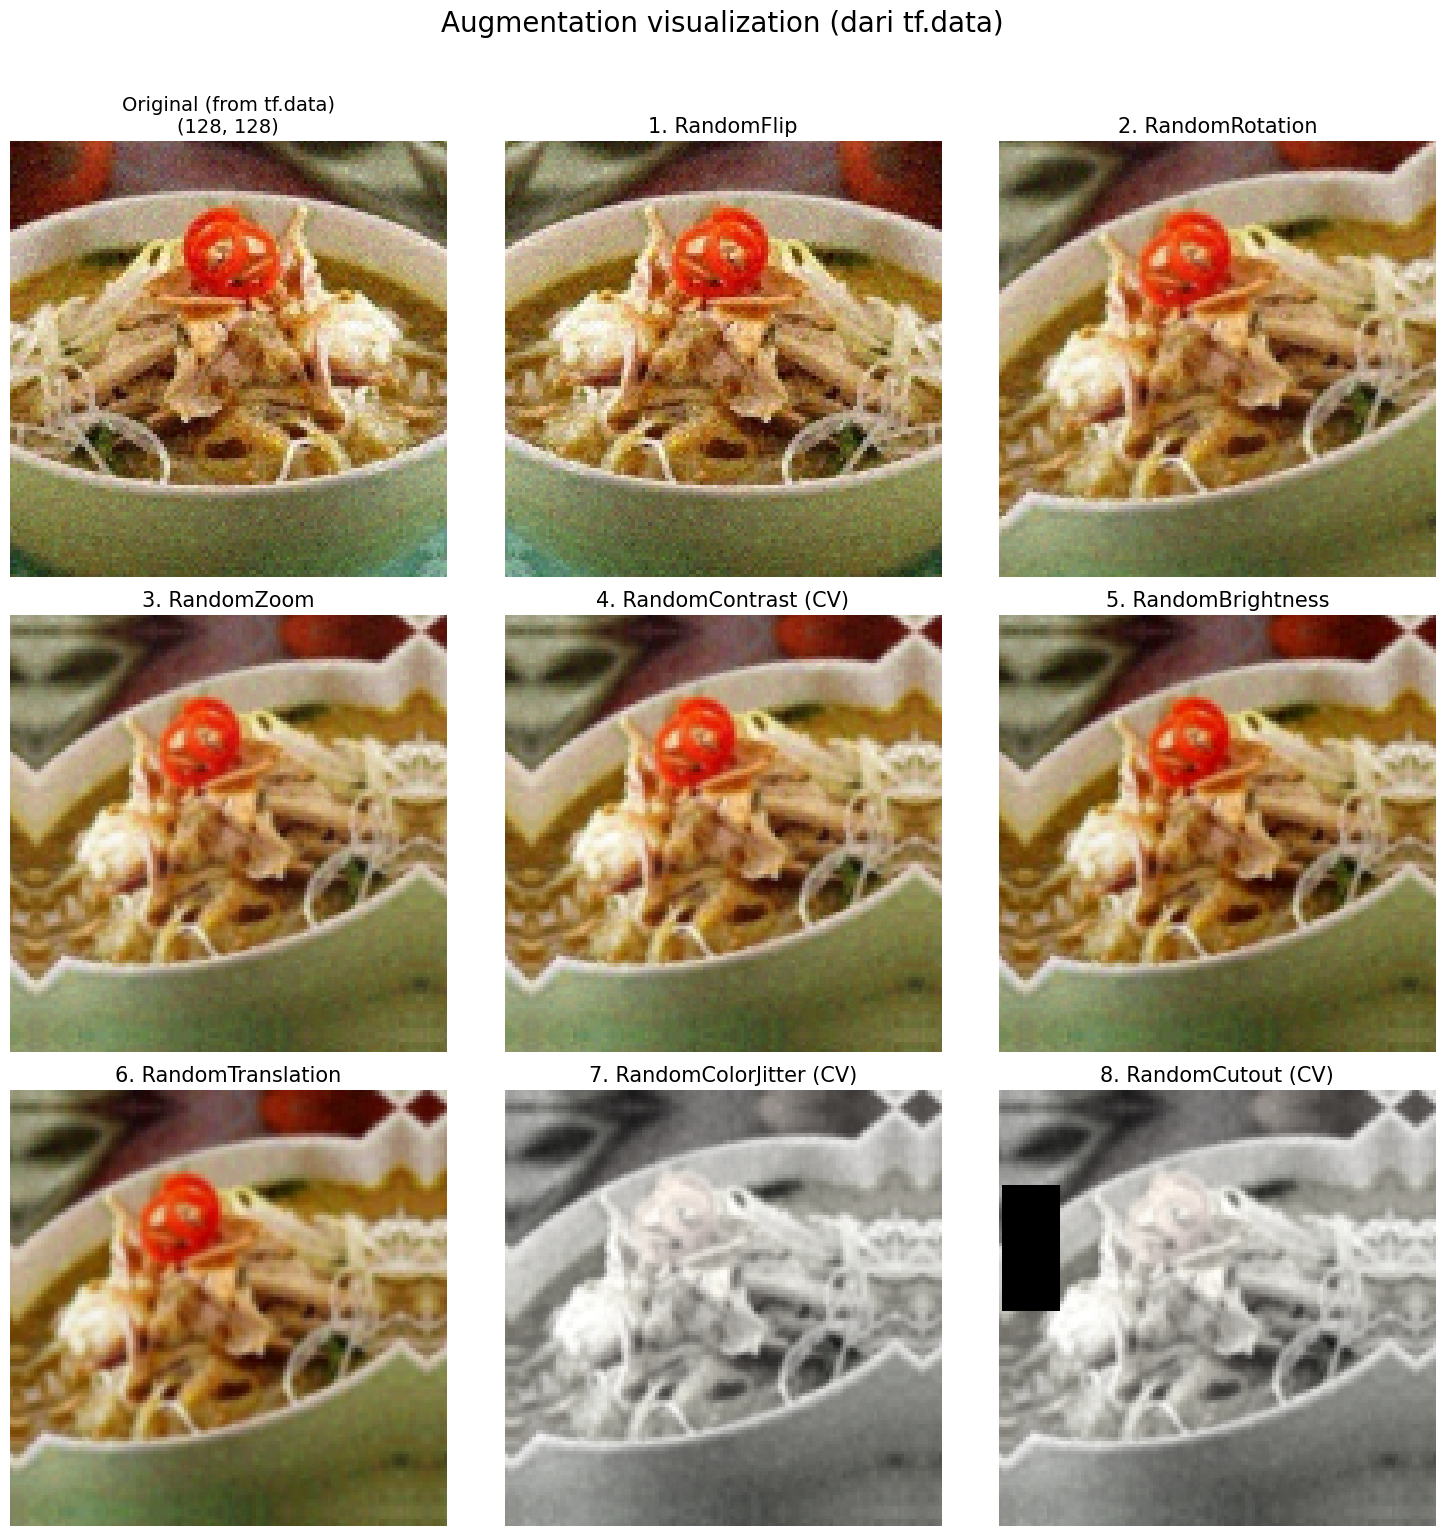

In [22]:
keras_layers = tf.keras.layers
keras_cv_layers = keras_cv.layers

aug_layers = [
    keras_layers.RandomFlip('horizontal'),
    keras_layers.RandomRotation(0.1),
    keras_layers.RandomZoom(height_factor=(0.0, 0.2), width_factor=(0.0,0.2)),
    keras_cv_layers.RandomContrast(factor=0.1, value_range=(0, 255)), 
    keras_layers.RandomBrightness(0.1, value_range=(0,255)), 
    keras_layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras_cv_layers.RandomColorJitter(value_range=(0, 255), 
                                       brightness_factor=0.1, 
                                       contrast_factor=0.1, 
                                       saturation_factor=0.1, 
                                       hue_factor=0.1),
    keras_cv_layers.RandomCutout(height_factor=0.3, width_factor=0.3)
]

aug_titles = [
    "1. RandomFlip", "2. RandomRotation", "3. RandomZoom",
    "4. RandomContrast (CV)", "5. RandomBrightness", "6. RandomTranslation",
    "7. RandomColorJitter (CV)", "8. RandomCutout (CV)"
]
sample_df = df.sample(n=1, random_state=SEED)
sample_path = sample_df['filepath'].values
sample_label = sample_df['label_enc'].values

vis_ds = build_dataset(
    sample_path,
    sample_label,
    batch_size=1,
    shuffle=False
)

augmented_batch, _ = next(iter(vis_ds))
original_tensor_image = augmented_batch[0] 

nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
axes = axes.flatten()

ax_orig = axes[0]
img_to_show = tf.cast(original_tensor_image, dtype=tf.uint8)

ax_orig.imshow(img_to_show.numpy()) 
ax_orig.set_title(f"Original (from tf.data)\n{IMG_SIZE}", fontsize=14)
ax_orig.axis('off')

for i, (layer, title) in enumerate(zip(aug_layers, aug_titles)):
    ax = axes[i + 1]
    augmented_batch = layer(augmented_batch) 
    augmented_img_float = augmented_batch[0]
    
    augmented_img_clipped = tf.clip_by_value(augmented_img_float, 0.0, 255.0)
    augmented_img_uint8 = tf.cast(augmented_img_clipped, dtype=tf.uint8)
    
    ax.imshow(augmented_img_uint8.numpy())
    ax.set_title(title, fontsize=15)
    ax.axis('off')

# Atur layout
fig.suptitle("Augmentation visualization (dari tf.data)", fontsize=20, y=1.02)
plt.tight_layout(pad=1.0)

plt.show()

## ConvNeXtTiny

ConvNeXtTiny adalah varian ringan dari keluarga ConvNeXt, arsitektur CNN modern yang menyederhanakan desain ResNet sambil mengadopsi praktik terbaik dari model visi mutakhir seperti normalisasi konsisten dan kernel yang lebih lebar sehingga ekstraksi fiturnya kuat namun efisien. Model ini dipilih karena memberikan keseimbangan baik antara akurasi dan biaya komputasi, mudah ditingkatkan performanya melalui transfer learning berbobot pralatih, serta mendukung fine-tuning bertahap untuk menambah kapasitas dengan risiko overfitting yang terkendali. Kombinasi efisiensi, stabilitas pelatihan, dan kualitas representasi membuatnya cocok sebagai backbone klasifikasi citra pada proyek dengan sumber daya terbatas tetapi menuntut hasil andal.

In [23]:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

def build_convnext_tiny():
    pretrained_convnext = ConvNeXtTiny(
        include_top=False,
        weights='imagenet',
        pooling=None,
        input_shape=(*IMG_SIZE, 3)
    )
    pretrained_convnext.trainable = False
    
    # Input
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = layers.RandomFlip('horizontal')(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(height_factor=(0.0, 0.25),
                          width_factor=(0.0,0.25)
                         )(x)
    x = layers.RandomContrast(0.1)(x)
    x = layers.RandomBrightness(0.1, value_range=(0,255))(x)
    x = layers.RandomTranslation(0.1, 0.1)(x)
    x = layers.RandomColorJitter(0.1)(x)
    x = keras_cv.layers.RandomCutout(height_factor=0.3,
                                     width_factor=0.3)(x)
    
    # Preprocessing
    x = convnext_preprocess(x)
    
    # Feature extractor
    x = pretrained_convnext(x, training=False)
    x = layers.GlobalAveragePooling2D()(x) 
    
    # Head
    x = layers.Dense(
        64, activation='relu',
        kernel_regularizer=regularizers.l2(1e-3)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(15, activation='softmax', dtype='float32')(x)
    
    model_convnext = keras.Model(inputs, outputs, name = 'convnext_food')
    
    callbacks_convnext = [
        EarlyStopping(
            monitor="val_loss", patience=6,
            restore_best_weights=True, verbose=1
        ),
        ModelCheckpoint(
            f"model_convnexttiny.weights.h5", monitor="val_accuracy",
            save_best_only=True, mode="max", verbose=0, save_weights_only=True
        )
    ]
    return model_convnext, pretrained_convnext, callbacks_convnext 

## EfficientNetV2S

EfficientNet-V2S adalah varian skala kecil dari keluarga EfficientNet-V2 yang menggabungkan blok konvolusi teroptimasi dan strategi pelatihan cepat sehingga mencapai akurasi tinggi dengan latensi rendah dan penggunaan memori hemat. Model ini cocok dipilih ketika proyek menuntut throughput yang baik pada gambar beresolusi sedang, karena arsitekturnya dirancang untuk efisiensi end-to-end, memanfaatkan bobot pralatih untuk transfer learning yang cepat, serta cenderung stabil saat fine-tuning pada dataset yang tidak terlalu besar. Keseimbangan antara kinerja, waktu pelatihan, dan kebutuhan komputasi menjadikannya pilihan praktis untuk sistem klasifikasi citra yang ingin tetap ringan tanpa mengorbankan akurasi.

In [24]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effnetv2s_preprocess

def build_efficientnet_v2s():
    pretrained_effnetv2s = EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        pooling=None,
        input_shape=(*IMG_SIZE, 3)
    )
    pretrained_effnetv2s.trainable = False
    
    # Input
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = layers.RandomFlip('horizontal')(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(height_factor=(0.0,0.25),
                          width_factor=(0.0,0.25)
                         )(x)
    x = layers.RandomContrast(0.1)(x)
    x = layers.RandomBrightness(0.1, value_range=(0,255))(x)
    x = layers.RandomTranslation(0.1, 0.1)(x)
    x = layers.RandomColorJitter(0.1)(x)
    x = keras_cv.layers.RandomCutout(height_factor=0.3,
                                     width_factor=0.3)(x)
    
    # Preprocessing
    x = effnetv2s_preprocess(x)
    
    # Feature extractor
    x = pretrained_effnetv2s(x, training=False)
    x = layers.GlobalAveragePooling2D()(x) 
    
    # Head
    x = layers.Dense(
        64, activation='relu',
        kernel_regularizer=regularizers.l2(1e-3)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(15, activation='softmax', dtype='float32')(x)
    
    model_effnetv2s = keras.Model(inputs, outputs)
    
    callbacks_effnetv2s = [
        EarlyStopping(
            monitor="val_loss", patience=6,
            restore_best_weights=True, verbose=1
        ),
        ModelCheckpoint(
            f"model_effnetv2s.weights.h5", monitor="val_accuracy",
            save_best_only=True, mode="max", verbose=0,
            save_weights_only=True
        )
    ]

    return model_effnetv2s, pretrained_effnetv2s, callbacks_effnetv2s

## DenseNet169

DenseNet-169 adalah jaringan konvolusional dengan koneksi padat antar lapisan sehingga setiap lapisan menerima fitur dari semua lapisan sebelumnya yang membantu aliran gradien lebih baik, pemanfaatan fitur lebih efektif, dan parameter lebih efisien. Arsitektur ini sering unggul ketika pola visual halus atau detail kecil perlu ditangkap, karena penggabungan fitur multi-level memperkaya representasi tanpa menambah ukuran model secara berlebihan. Dengan dukungan bobot pralatih dan sifatnya yang mudah disesuaikan melalui fine-tuning, DenseNet-169 menjadi pilihan kuat untuk meningkatkan akurasi pada tugas klasifikasi citra yang menuntut ketelitian dan generalisasi yang baik.

In [25]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

def build_densenet():
    pretrained_densenet = DenseNet169(
        include_top=False,
        weights='imagenet',
        pooling=None,
        input_shape=(*IMG_SIZE, 3)
    )
    pretrained_densenet.trainable = False
    
    # Input
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = layers.RandomFlip('horizontal')(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(height_factor=(0.0, 0.2),
                          width_factor=(0.0,0.2)
                         )(x)
    x = layers.RandomContrast(0.1)(x)
    x = layers.RandomBrightness(0.1, value_range=(0,255))(x)
    x = layers.RandomTranslation(0.1, 0.1)(x)
    x = layers.RandomColorJitter(0.1)(x)
    x = keras_cv.layers.RandomCutout(height_factor=0.3,
                                     width_factor=0.3)(x)
    
    # Preprocessing
    x = densenet_preprocess(x)
    
    # Feature extractor
    x = pretrained_densenet(x, training=False)
    x = layers.GlobalAveragePooling2D()(x) 
    
    # Head
    x = layers.Dense(
        64, activation='relu',
        kernel_regularizer=regularizers.l2(1e-3)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(15, activation='softmax', dtype='float32')(x)
    
    model_densenet = keras.Model(inputs, outputs)
    
    callbacks_densenet = [
        EarlyStopping(
            monitor="val_loss", patience=6,
            restore_best_weights=True, verbose=1
        ),
        ModelCheckpoint(
            f"model_inceptnet.weights.h5", monitor="val_accuracy",
            save_best_only=True, mode="max", verbose=0, save_weights_only=True,
        )
    ]

    return model_densenet, pretrained_densenet, callbacks_densenet

# 5. Training Method

In [26]:
def train_model(
    train_df, valid_df, model, pretrained_model, callbacks,
    head_epochs, head_lr, head_alpha, head_weight_decay, head_label_smoothing,
    fine_epochs, fine_lr, fine_alpha, fine_weight_decay, fine_label_smoothing,
    fine_use_ema, unfreeze_after
):
    train_ds, val_ds = build_splitted_ds(train_df, valid_df)

    try:
        steps_per_epoch = len(train_ds)
    except TypeError:
        print("Warning: Dataset tidak punya `len`. Atur steps_per_epoch manual jika perlu.")
        steps_per_epoch = train_df.shape[0] // BATCH_SIZE

    # Feature Extraction
    print(f"\n--- Phase 1: Feature Extraction ({head_epochs} epochs) ---")
    total_decay_steps_head = steps_per_epoch * head_epochs
    
    lr_schedule_head = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=head_lr, 
        decay_steps=total_decay_steps_head, 
        alpha=head_alpha
    )
    
    pretrained_model.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            lr_schedule_head, weight_decay=head_weight_decay
        ),
        loss=tf.keras.losses.CategoricalCrossentropy(
            label_smoothing=head_label_smoothing
        ),
        metrics=['accuracy']
    )
    
    history_head = model.fit(
        train_ds, 
        epochs=head_epochs, 
        validation_data=val_ds,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    # Fine Tuning
    print(f"\n--- Phase 2: Fine-Tuning ({fine_epochs} epochs) ---")
    total_decay_steps_fine = steps_per_epoch * fine_epochs
    
    lr_schedule_fine = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=fine_lr, 
        decay_steps=total_decay_steps_fine, 
        alpha=fine_alpha
    )
    
    # Logika Unfreeze
    pretrained_model.trainable = True  
    unfreeze_from_layer_name = unfreeze_after
    
    freeze_until_index = 0
    if unfreeze_from_layer_name is not None:
        for i, layer in enumerate(pretrained_model.layers):
            if layer.name == unfreeze_from_layer_name:
                freeze_until_index = i
                break
    
    print(f"Freezing first {freeze_until_index} layer...")
    for layer in pretrained_model.layers[:freeze_until_index]:
        layer.trainable = False
    
    optimizer_args = {
        "learning_rate": lr_schedule_fine,
        "weight_decay": fine_weight_decay
    }
    
    if fine_use_ema:
        optimizer_args.update({
            "use_ema": True,
            "ema_momentum": 0.999,
            "ema_overwrite_frequency": None
        })
        
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(**optimizer_args),
        loss=tf.keras.losses.CategoricalCrossentropy(
            label_smoothing=fine_label_smoothing
        ),
        metrics=['accuracy']
    )
    
    initial_epoch_fine = head_epochs
    total_epochs_fine = head_epochs + fine_epochs
    
    history_fine = model.fit(
        train_ds, 
        epochs=total_epochs_fine, 
        initial_epoch=initial_epoch_fine,
        validation_data=val_ds,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    return model, history_head, history_fine

## Configuration

In [27]:
# Config untuk EfficientNetV2S
config_effnet_v2s = {
    "head_epochs": 12, "head_lr": 1e-3, "head_alpha": 0.1,
    "head_weight_decay": 1e-4, "head_label_smoothing": 0.15,
    
    "fine_epochs": 15, "fine_lr": 1e-4, "fine_alpha": 0.1,
    "fine_weight_decay": 5e-4, "fine_label_smoothing": 0.1,
    "fine_use_ema": True,
    
    "unfreeze_after": "block6a_expand_conv",
}

# Config untuk ConvNeXtTiny
config_convnext = {
    "head_epochs": 12, "head_lr": 1e-3, "head_alpha": 0.1,
    "head_weight_decay": 1e-4, "head_label_smoothing": 0.15,
    
    "fine_epochs": 15, "fine_lr": 1e-4, "fine_alpha": 0.1,
    "fine_weight_decay": 2e-4, "fine_label_smoothing": 0.1,
    "fine_use_ema": True, 
    
    "unfreeze_after": "convnext_tiny_stage_3_block_0_depthwise_conv",
}

# Config untuk DenseNet169
config_densenet = {
    "head_epochs": 12, "head_lr": 1e-3, "head_alpha": 0.1,
    "head_weight_decay": 1e-4, "head_label_smoothing": 0.15,
    
    "fine_epochs": 15, "fine_lr": 1e-4, "fine_alpha": 0.1,
    "fine_weight_decay": 5e-4, "fine_label_smoothing": 0.1,
    "fine_use_ema": True,
    
    "unfreeze_after": "conv5_block1_0_bn",
}

# model and config
MODEL_PIPELINE = {
    "EfficientNetV2S": {
        "build_fn": build_efficientnet_v2s, "config": config_effnet_v2s
    },
    "ConvNeXtTiny": {
        "build_fn": build_convnext_tiny,    "config": config_convnext
    },
    "DenseNet169": {
        "build_fn": build_densenet,"config": config_densenet
    }
}

## Training Loop

In [28]:
oof_preds = {model_name: [] for model_name in MODEL_PIPELINE.keys()}
oof_labels = []
models = {}
head_history = {}
fine_history = {}
model_scores = {}

train_data = train_df
val_data = test_df

fold_true_labels = val_data['label_enc'].values 
oof_labels.append(fold_true_labels)

for model_name, pipeline in MODEL_PIPELINE.items():
    print(f"\n=== Training {model_name} ===")
    
    # Build model
    untrained_model, pretrained_model, callbacks = pipeline["build_fn"]()
    config = pipeline["config"]
    
    # Training Phase 
    model_out, head_hist, fine_hist = train_model(
        train_df=train_data, valid_df=val_data,
        model=untrained_model, pretrained_model=pretrained_model,
        callbacks=callbacks, **config
    )
    
    # Save_Result
    models[model_name] = model_out
    head_history[model_name] = head_hist.history
    fine_history[model_name] = fine_hist.history
    
    # Highest Validation Acc
    best_score = max(fine_hist.history['val_accuracy'])
    model_scores[model_name] = best_score
    print(f"Model {model_name} trained, Best Val Acc: {best_score:.4f}")

    print(f"OOF Prediction of {model_name}...")
    pred_dataset = build_dataset(
        paths=val_data['filepath'].values,
        labels=val_data['label_enc'].values,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    fold_oof_predictions = model_out.predict(pred_dataset, verbose=0) 
    
    oof_preds[model_name].append(fold_oof_predictions)
    print(f"OOF Prediction of {model_name} saved succesfully.")
    
    del model_out
    tf.keras.backend.clear_session()


=== Training DenseNet169 ===
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Phase 1: Feature Extraction (12 epochs) ---
Epoch 1/12


I0000 00:00:1762876560.322204     116 service.cc:148] XLA service 0x78b490050a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762876560.322820     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762876560.322847     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762876560.353831     116 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762876560.435367     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 ━━━━━━━━━━━━━━━━━━━━ 75s 156ms/step - accuracy: 0.1517 - loss: 3.1375 - val_accuracy: 0.5141 - val_loss: 1.9282
Epoch 2/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 214ms/step - accuracy: 0.3588 - loss: 2.2787 - val_accuracy: 0.4540 - val_loss: 2.1204
Epoch 3/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4555 - loss: 2.0997 - val_accuracy: 0.6394 - val_loss: 1.6841
Epoch 4/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4729 - loss: 2.0030 - val_accuracy: 0.6330 - val_loss: 1.7066
Epoch 5/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4930 - loss: 1.9854 - val_accuracy: 0.6368 - val_loss: 1.6746
Epoch 6/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5119 - loss: 1.9412 - val_accuracy: 0.6471 - val_loss: 1.6686
Epoch 7/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5281 - loss: 1.9232 - val_accuracy: 0.6535 - val_loss: 1.6654
Epoch 8/12
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5595 - loss: 1.8913 - val_accuracy: 0

# 6. Model Evaluation

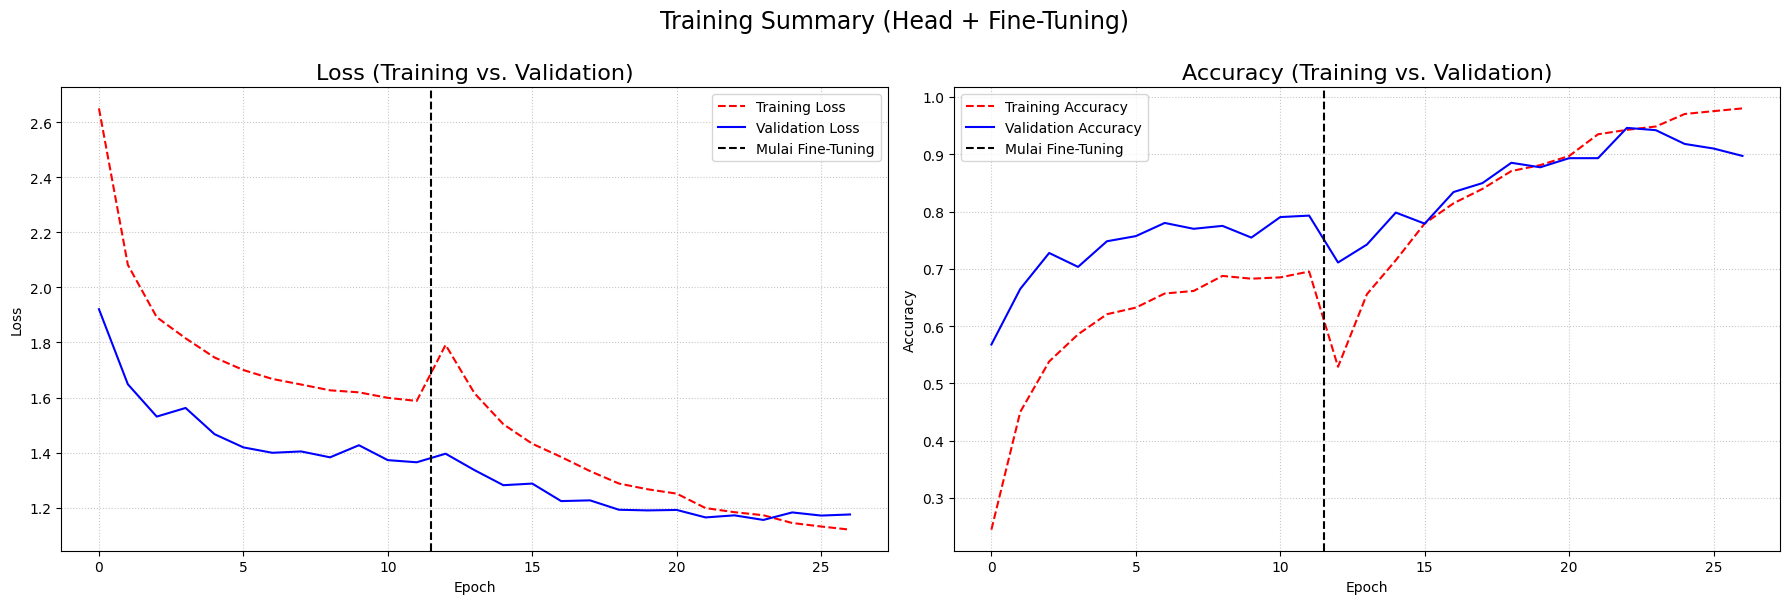

In [23]:
training_history(head_history['DenseNet169'], fine_history['DenseNet169'])

In [30]:
import numpy as np

print("\n=== All Loops Are Finished! ===")
print("Concatenating OOF...")
y_meta_train = np.concatenate(oof_labels, axis=0)

list_of_feature_arrays = []
for model_name, preds_list in oof_preds.items():
    full_preds_array = np.concatenate(preds_list, axis=0)
    list_of_feature_arrays.append(full_preds_array)
    print(f" - Fitur {model_name} digabungkan, shape: {full_preds_array.shape}")

X_meta_train = np.hstack(list_of_feature_arrays)

print("\n=== Meta Learner Made Succesfully ===")


=== All Loops Are Finished! ===
Concatenating OOF...
 - Fitur DenseNet169 digabungkan, shape: (782, 15)

=== Meta Learner Made Succesfully ===


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

meta_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(
        max_iter=10000, 
        multi_class='auto',
        random_state=42,
        n_jobs=-1
    ))
])

scores_logreg = cross_val_score(
    pipeline_lr,
    X_meta_train, 
    y_meta_train, 
    cv=meta_cv, 
    scoring='accuracy'
)

print(f"\n[LogisticRegression Meta-Learner] CV 5-Fold Accuracy:")
print(f"Scores: {np.round(scores_logreg, 4)}")
print(f"Average Accuracy: {np.mean(scores_logreg):.4f} (+/- {np.std(scores_logreg):.4f})")


[LogisticRegression Meta-Learner] CV 5-Fold Accuracy:
Scores: [0.7452 0.8025 0.7756 0.8397 0.7436]
Average Accuracy: 0.7813 (+/- 0.0364)


In [32]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import lightgbm as lgb
import numpy as np

meta_learner = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(
        max_iter=1000, 
        multi_class='auto',
        random_state=42,
        n_jobs=-1
    ))
])

meta_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Membuat prediksi OOF (meta-learner) dengan 10-Fold CV...")
y_pred_oof = cross_val_predict(
    meta_learner,
    X_meta_train,
    y_meta_train,
    cv=meta_cv
)
accuracy = accuracy_score(y_meta_train, y_pred_oof)

print("\n--- Hasil Akurasi Ensemble (Validasi OOF) ---")
print(f"Akurasi Meta-Learner (Ensemble): {accuracy * 100:.2f}%")

print("\nLaporan Klasifikasi Rinci (OOF):")
print(classification_report(y_meta_train, y_pred_oof))

meta_learner.fit(X_meta_train, y_meta_train)

Membuat prediksi OOF (meta-learner) dengan 10-Fold CV...

--- Hasil Akurasi Ensemble (Validasi OOF) ---
Akurasi Meta-Learner (Ensemble): 78.13%

Laporan Klasifikasi Rinci (OOF):
              precision    recall  f1-score   support

           0       0.78      0.81      0.80        53
           1       0.78      0.77      0.77        47
           2       0.70      0.75      0.73        53
           3       0.83      0.90      0.86        49
           4       0.78      0.89      0.84        57
           5       0.75      0.79      0.77        52
           6       0.75      0.77      0.76        53
           7       0.71      0.73      0.72        49
           8       0.85      0.73      0.79        56
           9       0.84      0.79      0.82        53
          10       0.67      0.63      0.65        49
          11       0.86      0.79      0.83        48
          12       0.82      0.79      0.80        57
          13       0.85      0.82      0.83        49
          1

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=42))])

# 7. Predict Test

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

preprocess_map = {
    'ConvNeXtTiny': convnext_preprocess,
    'EfficientNetV2S': effnetv2s_preprocess,
    'DenseNet169':densenet_preprocess
}

def simple_predict(model, X_data, preprocess_function, batch_size=32):
    num_samples = len(X_data)
    all_preds = []
    print(f"Memprediksi {num_samples} sampel dalam batch {batch_size}...")
    for i in range(0, num_samples, batch_size):
        batch_raw = X_data[i:i+batch_size]
        preprocessed_batch = preprocess_function(batch_raw.copy()) 
        batch_preds = model.predict(preprocessed_batch, verbose=0)
        all_preds.append(batch_preds)
    return np.concatenate(all_preds, axis=0)

print("Memuat gambar tes (mentah [0, 255])...")
X_test_raw, test_filenames = load_test_images(TEST_DIR, IMG_SIZE)
print(f"Berhasil memuat {len(X_test_raw)} gambar tes.")

meta_features_test_list = []

print("\nMemulai prediksi test set (untuk meta-learner)...")

for arch_key in MODEL_PIPELINE.keys(): 
    print(f"\n--- Memproses Arsitektur: {arch_key} ---")
    
    models_for_this_arch = []
    for model_name, model_obj in models.items():
        if arch_key in model_name:
            models_for_this_arch.append(model_obj)
            
    if not models_for_this_arch:
        print(f"PERINGATAN: Tidak ada model yang ditemukan untuk {arch_key}. Dilewati.")
        continue
        
    print(f"Ditemukan {len(models_for_this_arch)} model fold untuk arsitektur ini.")

    preprocess_func = preprocess_map.get(arch_key)
    if not preprocess_func:
        print(f"PERINGATAN: Tidak ditemukan preprocessor untuk {arch_key}. Dilewati.")
        continue
        
    print(f"Menggunakan preprocessor: {preprocess_func.__name__}")

    all_fold_preds = []
    for i, model in enumerate(models_for_this_arch):
        print(f"Memprediksi dengan fold {i+1}/{len(models_for_this_arch)}...")
        preds_fold = simple_predict(model, X_test_raw, preprocess_func)
        all_fold_preds.append(preds_fold)
        
    avg_preds = np.mean(np.stack(all_fold_preds, axis=0), axis=0)
    print(f"Shape prediksi rata-rata untuk {arch_key}: {avg_preds.shape}")

    meta_features_test_list.append(avg_preds)

if meta_features_test_list and len(meta_features_test_list) == len(MODEL_PIPELINE):
    meta_features_test = np.hstack(meta_features_test_list)
    
    print(f"Shape meta-features (test): {meta_features_test.shape}")
    
    print("Final Predict with meta learner")
  
    final_predictions_idx = meta_learner.predict(meta_features_test)
    predicted_classnames = [class_names[i] for i in final_predictions_idx]

    submission_df = pd.DataFrame({
        "ID": [int(os.path.splitext(f)[0]) for f in test_filenames],
        "label": predicted_classnames
    }).sort_values('ID')

    submission_df.to_csv('submission_stacking_ensemble.csv', index=False)
    print(f"Submission (Stacka) berhasil disimpan ke submission_stacking_ensemble.csv")
else:
    print("Prediksi tidak lengkap. Pastikan semua arsitektur berhasil diproses.")

In [ ]:
submission_df.head(20)

In [ ]:
submission_df['label'].value_counts()